In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder, train_folder, intermediate_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd
from ipywidgets import interact, widgets

In [2]:
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

In [4]:
folders_list = sorted(os.listdir(os.path.join(raw_folder, 'second attempt')))
type_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='source: ',
)
display(type_dropdown)

Dropdown(description='source: ', index=1, options=('test', 'train'), value='train')

In [5]:
folders_list = sorted(os.listdir(os.path.join(raw_folder, 'second attempt', type_dropdown.value)))
folder_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[0],
    description='folder: ',
)
display(folder_dropdown)

Dropdown(description='folder: ', options=('1039-2088DA037-3', '1039-2088DA037-4', '1039-2088DA039-3', '1039-2088DA039-4'), value='1039-2088DA037-3')

In [6]:
annotation_folder = os.path.join(raw_folder,'second attempt', type_dropdown.value, folder_dropdown.value)
#print(annotation_folder)
#print(os.path.isdir(annotation_folder))
tifs = sorted(glob.glob( annotation_folder + '/*.tif'))
#print('no of tifs: {}'.format(len(tifs)))
#
images_dropdown = widgets.Dropdown(
    options=tifs,
    value=tifs[0],
    description='image: ',
)
display(images_dropdown)

Dropdown(description='image: ', options=('/media/deepinfer/mehrtash2/qanat/raw/second attempt/train/1039-2088DA037-3/1039-2088DA037-3.tif',), value='/media/deepinfer/mehrtash2/qanat/raw/second attempt/train/1039-2088DA037-3/1039-2088DA037-3.tif')

In [7]:
tif_path = images_dropdown.value
image = sitk.ReadImage(tif_path)
nda = sitk.GetArrayFromImage(image)

In [8]:
labels = sorted(glob.glob(raw_folder + '/' + os.path.basename(tif_path).split('.')[0] + '_label_*.nrrd'))
print('no of labels: {}'.format(len(labels)))
labels_dropdown = widgets.Dropdown(
    options=labels,
    value=labels[0],
    description='image: ',
)
display(labels_dropdown)

no of labels: 2


Dropdown(description='image: ', options=('/media/deepinfer/mehrtash2/qanat/raw/1039-2088DA037-3_label_1.nrrd', '/media/deepinfer/mehrtash2/qanat/raw/1039-2088DA037-3_label_2.nrrd'), value='/media/deepinfer/mehrtash2/qanat/raw/1039-2088DA037-3_label_1.nrrd')

In [139]:
label_path = labels_dropdown.value
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)

In [140]:
roi_path = label_path.replace('.nrrd', '_roi.acsv')
roi_points = np.zeros((2,2))
i = 0
with open(roi_path) as f:
    for line in f.readlines():
        if line.startswith('point'):
            p = line.split('|')
            roi_points[i,0] = -float(p[1])
            roi_points[i,1] = -float(p[2])
            i += 1
center = list(roi_points[0])
center = np.asarray(image.TransformPhysicalPointToIndex(center))
spacing = image.GetSpacing()
length = np.abs(roi_points[1]/spacing).astype(np.int)
start = center - length
end = center + length

In [141]:
cmap = colors.ListedColormap(['orange', 'red'])

In [142]:
roi_nda= nda[start[1]:end[1], start[0]:end[0]]
roi_mask_nda = label_mask[start[1]:end[1], start[0]:end[0]]
roi_image = sitk.GetImageFromArray(roi_nda)
roi_mask = sitk.GetImageFromArray(roi_mask_nda)
roi_mask.CopyInformation(roi_image)

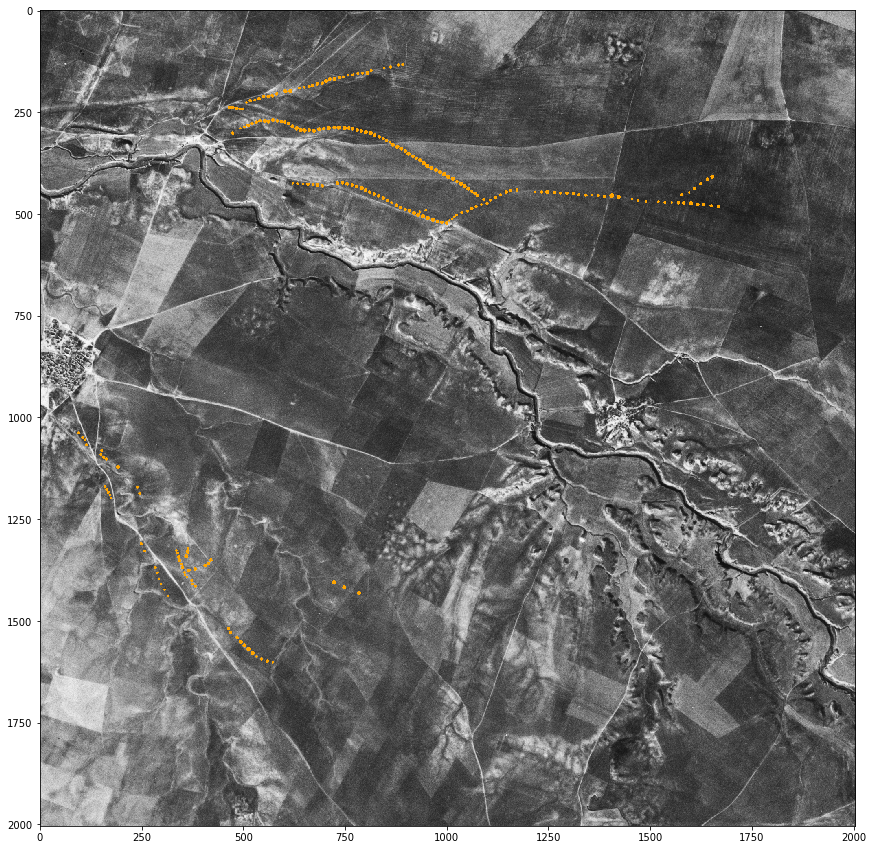

In [143]:
#
plt.figure(figsize=(15,15))
plt.imshow(roi_nda, cmap=plt.cm.gray)
plt.imshow(roi_mask_nda, alpha=1, cmap=cmap)

In [144]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
roi_mask_ccf = ccf.Execute(roi_mask)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(roi_mask_ccf, roi_mask_ccf)
labels = list(stats_filter.GetLabels())
labels.remove(0)
print(len(labels))

212


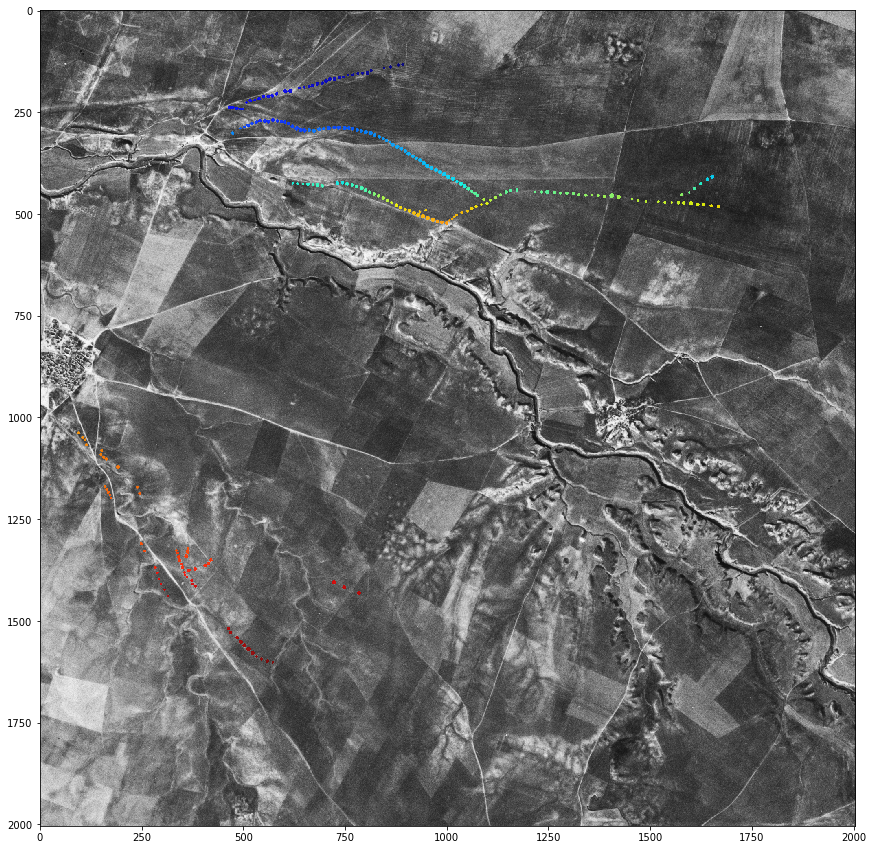

In [145]:
plt.figure(figsize=(15,15))
roi_mask_ccf_nda = sitk.GetArrayFromImage(roi_mask_ccf).squeeze()
roi_mask_ccf_nda = np.ma.masked_where(roi_mask_ccf_nda== 0, roi_mask_ccf_nda)
plt.imshow(roi_nda, cmap=plt.cm.gray)
plt.imshow(roi_mask_ccf_nda, alpha=0.9,cmap=plt.cm.jet)

In [146]:
stats_filter.Execute(roi_mask_ccf, roi_mask_ccf)
for label_value in labels:
    bb = np.asarray(stats_filter.GetBoundingBox(label_value))
    count = stats_filter.GetCount(label_value)
    print('label value: {}, count: {}'.format(label_value, count))

label value: 1, count: 50
label value: 2, count: 52
label value: 3, count: 52
label value: 4, count: 28
label value: 5, count: 40
label value: 6, count: 82
label value: 7, count: 41
label value: 8, count: 40
label value: 9, count: 40
label value: 10, count: 40
label value: 11, count: 40
label value: 12, count: 51
label value: 13, count: 75
label value: 14, count: 216
label value: 15, count: 59
label value: 16, count: 96
label value: 17, count: 39
label value: 18, count: 40
label value: 19, count: 80
label value: 20, count: 79
label value: 21, count: 51
label value: 22, count: 50
label value: 23, count: 58
label value: 24, count: 56
label value: 25, count: 59
label value: 26, count: 39
label value: 27, count: 51
label value: 28, count: 28
label value: 29, count: 117
label value: 30, count: 98
label value: 31, count: 28
label value: 32, count: 58
label value: 33, count: 58
label value: 34, count: 152
label value: 35, count: 58
label value: 36, count: 59
label value: 37, count: 58
label v

In [147]:
count_threshold = 100
d = []
pd.DataFrame(d)
erode_filter = sitk.BinaryErodeImageFilter()
erode_filter.SetKernelRadius([3,0,3])
erode_filter.SetBackgroundValue(0)
for label_value in labels:
    print(label_value)
    bb = np.asarray(stats_filter.GetBoundingBox(label_value))
    count = stats_filter.GetCount(label_value)
    if count > count_threshold:
        print('eroding')
        erode_filter.SetForegroundValue(label_value)
        roi_mask_ccf = erode_filter.Execute(roi_mask_ccf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
eroding
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
eroding
30
31
32
33
34
eroding
35
36
37
38
eroding
39
eroding
40
eroding
41
42
43
44
45
46
eroding
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
eroding
62
eroding
63
64
65
66
eroding
67
eroding
68
69
70
71
72
73
74
75
76
77
78
79
eroding
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
eroding
98
99
100
101
102
103
104
105
106
107
108
109
110
111
eroding
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
eroding
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
eroding
183
eroding
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212


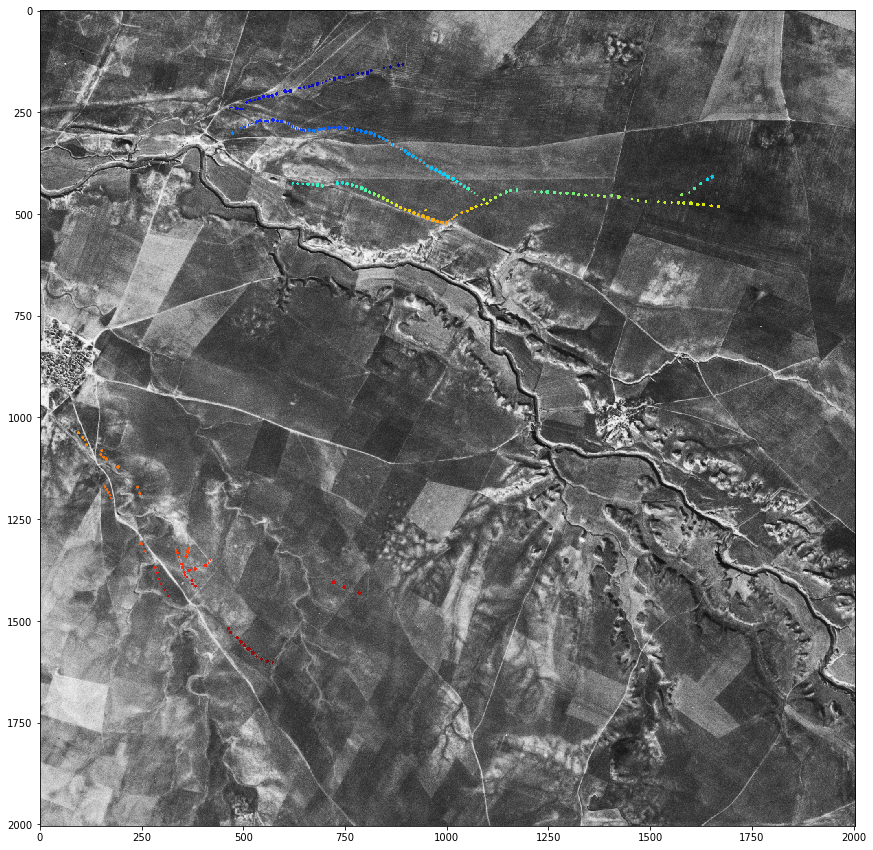

In [148]:
plt.figure(figsize=(15,15))
roi_mask_ccf_nda = sitk.GetArrayFromImage(roi_mask_ccf).squeeze()
roi_mask_ccf_nda = np.ma.masked_where(roi_mask_ccf_nda== 0, roi_mask_ccf_nda)
plt.imshow(roi_nda, cmap=plt.cm.gray)
plt.imshow(roi_mask_ccf_nda, alpha=0.9,cmap=plt.cm.jet)

In [149]:
stats_filter.Execute(roi_mask_ccf, roi_mask_ccf)
for label_value in labels:
    bb = np.asarray(stats_filter.GetBoundingBox(label_value))
    count = stats_filter.GetCount(label_value)
    print('label value: {}, count: {}'.format(label_value, count))

label value: 1, count: 50
label value: 2, count: 52
label value: 3, count: 52
label value: 4, count: 28
label value: 5, count: 40
label value: 6, count: 82
label value: 7, count: 41
label value: 8, count: 40
label value: 9, count: 40
label value: 10, count: 40
label value: 11, count: 40
label value: 12, count: 51
label value: 13, count: 75
label value: 14, count: 61
label value: 15, count: 59
label value: 16, count: 96
label value: 17, count: 39
label value: 18, count: 40
label value: 19, count: 80
label value: 20, count: 79
label value: 21, count: 51
label value: 22, count: 50
label value: 23, count: 58
label value: 24, count: 56
label value: 25, count: 59
label value: 26, count: 39
label value: 27, count: 51
label value: 28, count: 28
label value: 29, count: 40
label value: 30, count: 98
label value: 31, count: 28
label value: 32, count: 58
label value: 33, count: 58
label value: 34, count: 71
label value: 35, count: 58
label value: 36, count: 59
label value: 37, count: 58
label valu

In [150]:
hough_radii = np.arange(1, 2, 1)
hough_res = hough_circle(roi_mask_ccf_nda, hough_radii)
# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1000)

In [151]:
label_circles = np.zeros(roi_mask_ccf_nda.shape)
for center_y, center_x, radius in zip(cy, cx, radii):
    #label_circles[center_y-1:center_y, center_x-1:center_x] = 1
    circy, circx = circle_perimeter(center_y, center_x, radius)
    label_circles[circy, circx] = 1

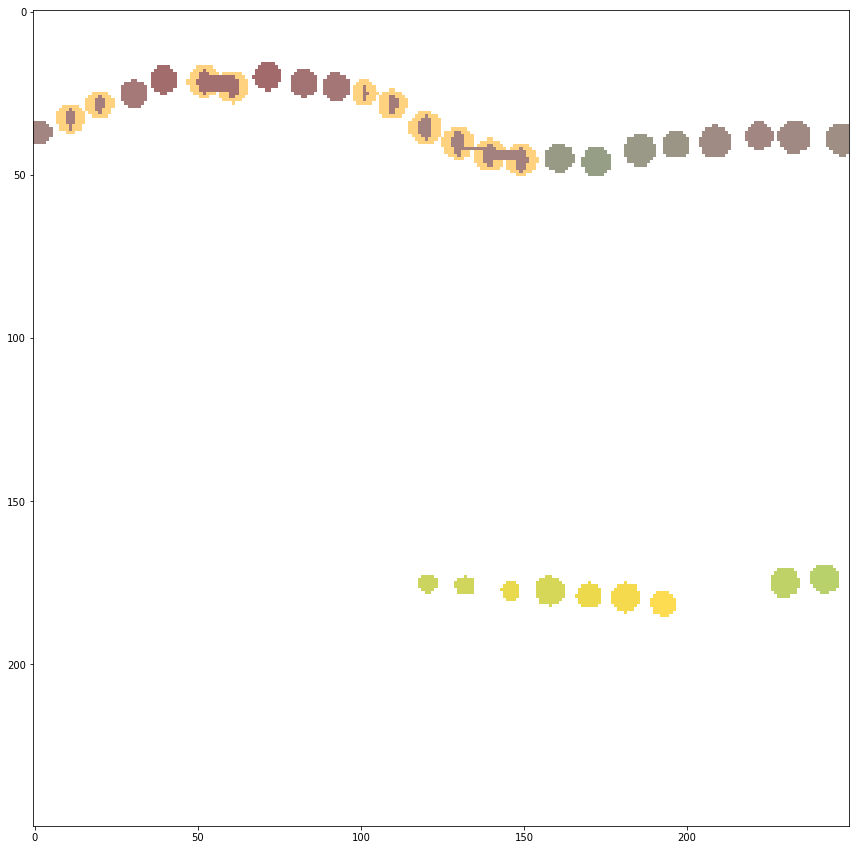

In [152]:
plt.figure(figsize=(15,15))
#plt.imshow(roi_nda[250:500, 500:750],alpha=1, cmap=plt.cm.gray)
roi_mask_ccf_nda = np.ma.masked_where(roi_mask_ccf_nda== 0, roi_mask_ccf_nda)
plt.imshow(roi_mask_nda[250:500, 500:750],alpha=0.5,cmap=cmap)
plt.imshow(roi_mask_ccf_nda[250:500, 500:750],alpha=0.5)
#plt.imshow(label_circles[250:500, 500:750],alpha=0.5, cmap=cmap)